In [1]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
from cellpose import utils, io
from PIL import Image
import cv2

my_data = "/home/keeganfl/Desktop/Math_612_project/05-10-2015/Height/"
save_path = "/home/keeganfl/Desktop/Math_612_project/05-10-2015/cellpose_height/"

## Step 1: 
Create a list of files that contains the path for everything in your folder of images. 

In [2]:
files = os.listdir(my_data)
for fichier in files[:]: # filelist[:] makes a copy of filelist.
    if not(fichier.endswith(".png")):
        files.remove(fichier)

save_names = [save_path + file for file in files]
file_names = [my_data + file for file in files]

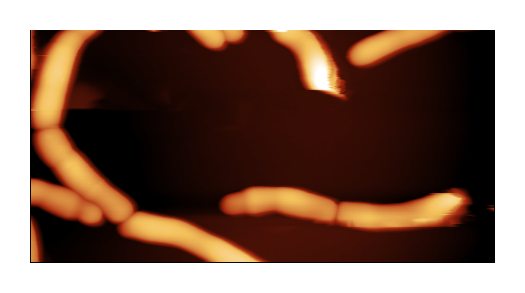

In [3]:
# view 1 image
img = io.imread(file_names[9])
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.axis('off')
plt.show()

## Step 2:
Running cellpose on every file within our data folder and saving the output to our save path. 

In [4]:
# RUN CELLPOSE

from cellpose import models, io

# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=False, model_type='cyto')

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
channels = [0,0]

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended) 
# diameter can be a list or a single number for all images

# you can run all in a list e.g.
# >>> imgs = [io.imread(filename) in for filename in files]
# >>> masks, flows, styles, diams = model.eval(imgs, diameter=None, channels=channels)
# >>> io.masks_flows_to_seg(imgs, masks, flows, diams, files, channels)
# >>> io.save_to_png(imgs, masks, flows, files)

# or in a loop
for filename, savename in zip(file_names, save_names):
    img = io.imread(filename)
    masks, flows, styles, diams = model.eval(img, diameter=None, channels=channels)

    # save results so you can load in gui
    io.masks_flows_to_seg(img, masks, flows, diams, savename, channels)

    # save results as png
    # io.save_to_png(img, masks, flows, savename)

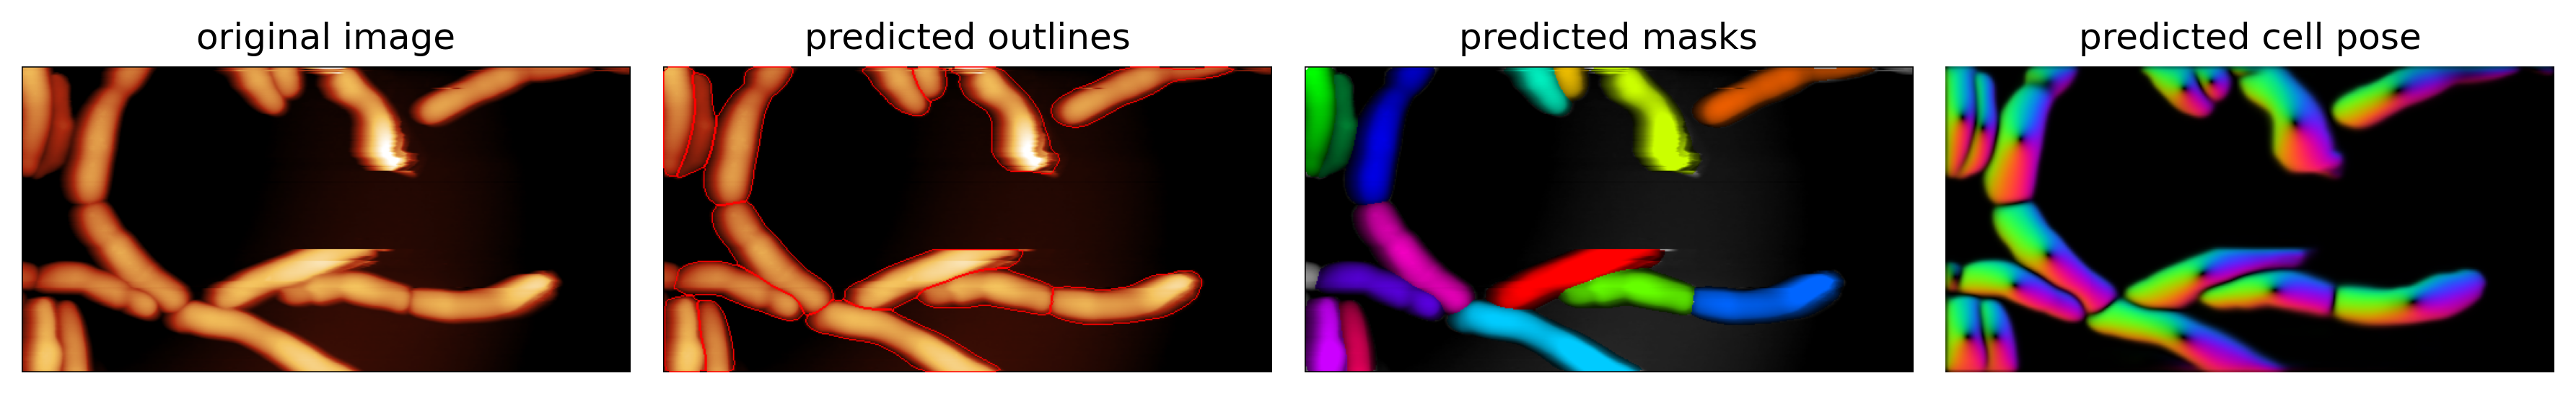

In [5]:
# DISPLAY RESULTS
from cellpose import plot

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img, masks, flows[0], channels=channels)
plt.tight_layout()
plt.show()

useful utils may include:
- fill_holes_and_remove_small_masks
- get_mask_compactness
- get_mask_stats
- distance_to_boundary. This determines the distance of each pixel in a mask to the boundaries (I think). If I find the max of this it might help me find a center, although the rod shape may screw with that. 
- radius distribution 
- metrics 
- remove_edge_masks. This removes any mask that has a pixel on the edge of the image, might be helpful when cleaning up images. Would have to be careful not to screw with the metadata. Hmm, this does not work so good

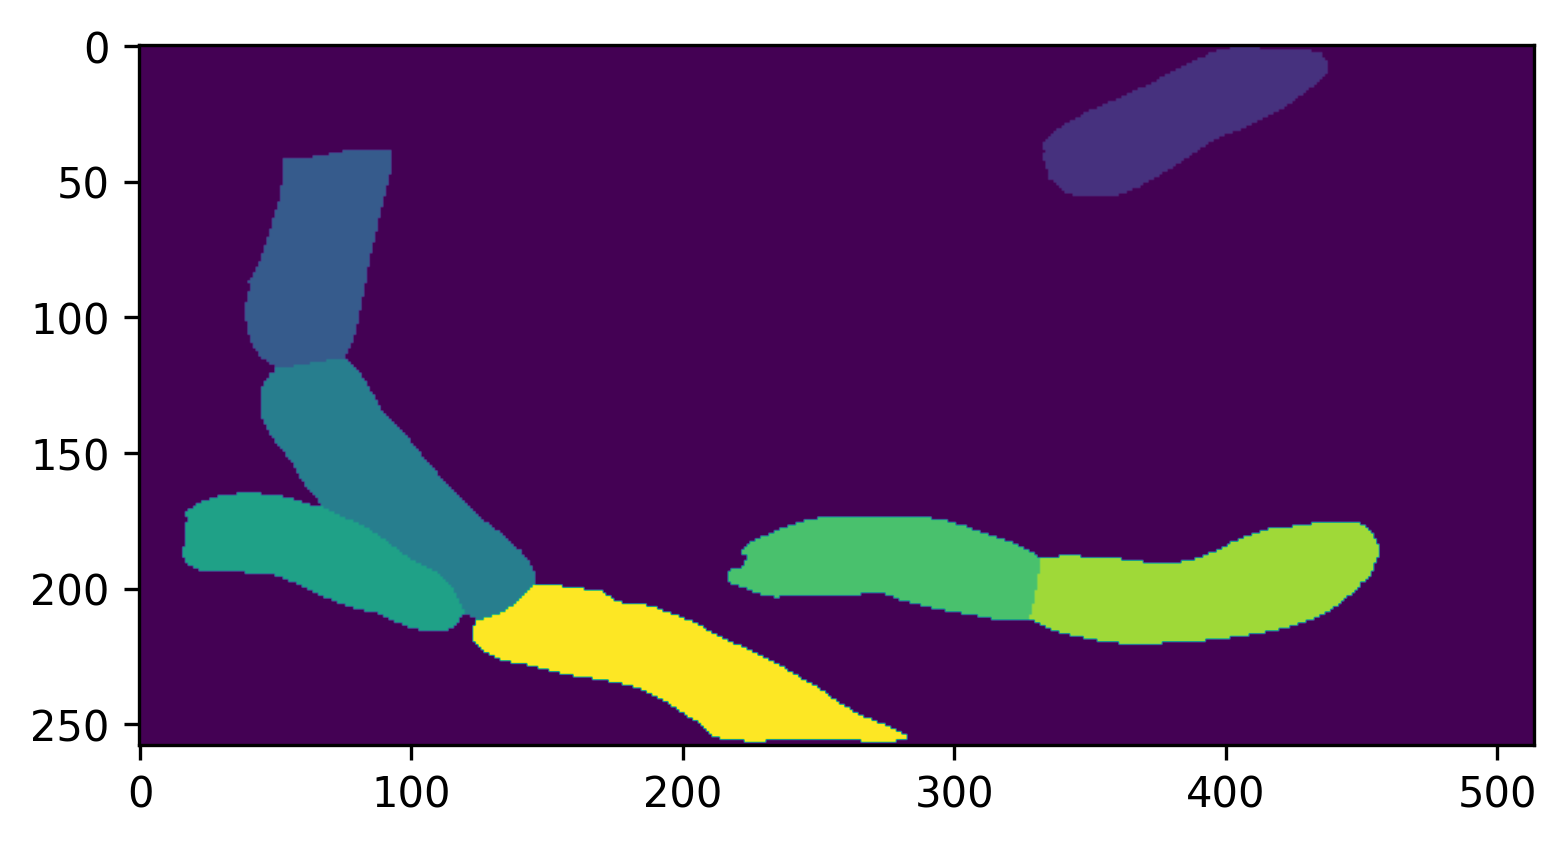

In [22]:
# Ok, I need to go hard to make this work.
###!!!### Also, I still do not understand why remove edge masks does not function. 
plt.imshow(utils.fill_holes_and_remove_small_masks(dat['masks'], min_size = 2000))

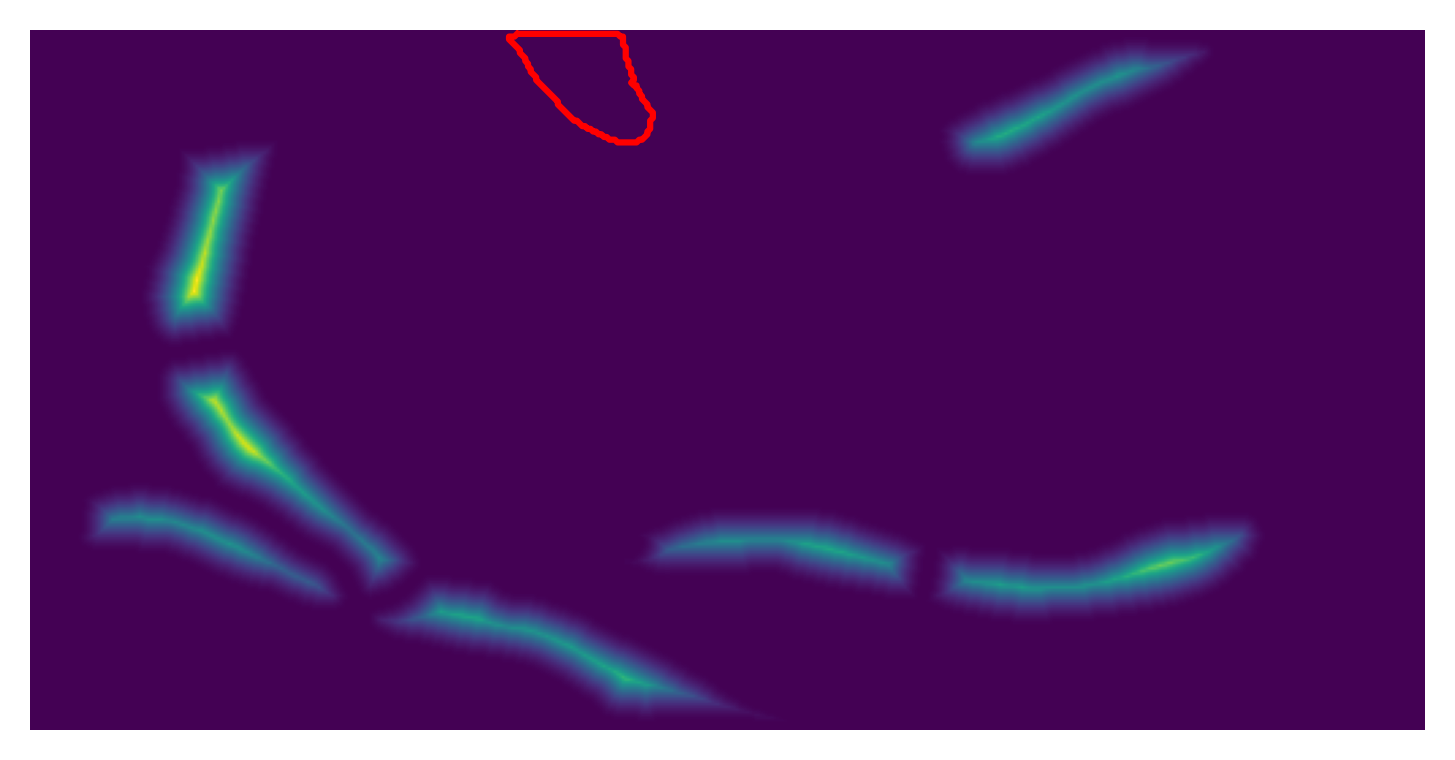

In [23]:
plt.imshow(utils.distance_to_boundary(dat['masks']))
# plot an individual cell of choice. 
plt.plot(outl[2][:,0], outl[2][:,1], color = "r")
plt.axis("off")
plt.savefig("test.png")

# Goals:
- Find center of all contours. Completed!!!
- Calculate if contours are touching each other and how much overlap there is. 
- Tell how distant the cell was from other contours in general? 
- Where was the cell in the overall image. 
- What was the time point of this image. Can calculate based on image name? 
- Use optical flow to track cell movement on a basic level. 
- Find a way to auto filter those weird looking cells. 
- What am I going to do when the pngs seem to change size randomly? Will any tracking I implement be able to cope? 
- How do I determine of cells are dividing vs being smushed together? Need the help of the actual data points? only bacteria connected pole to pole are touching? Take into account the time tracking? Maybe it should have an event for when a new cell appears. 

### determining overlap

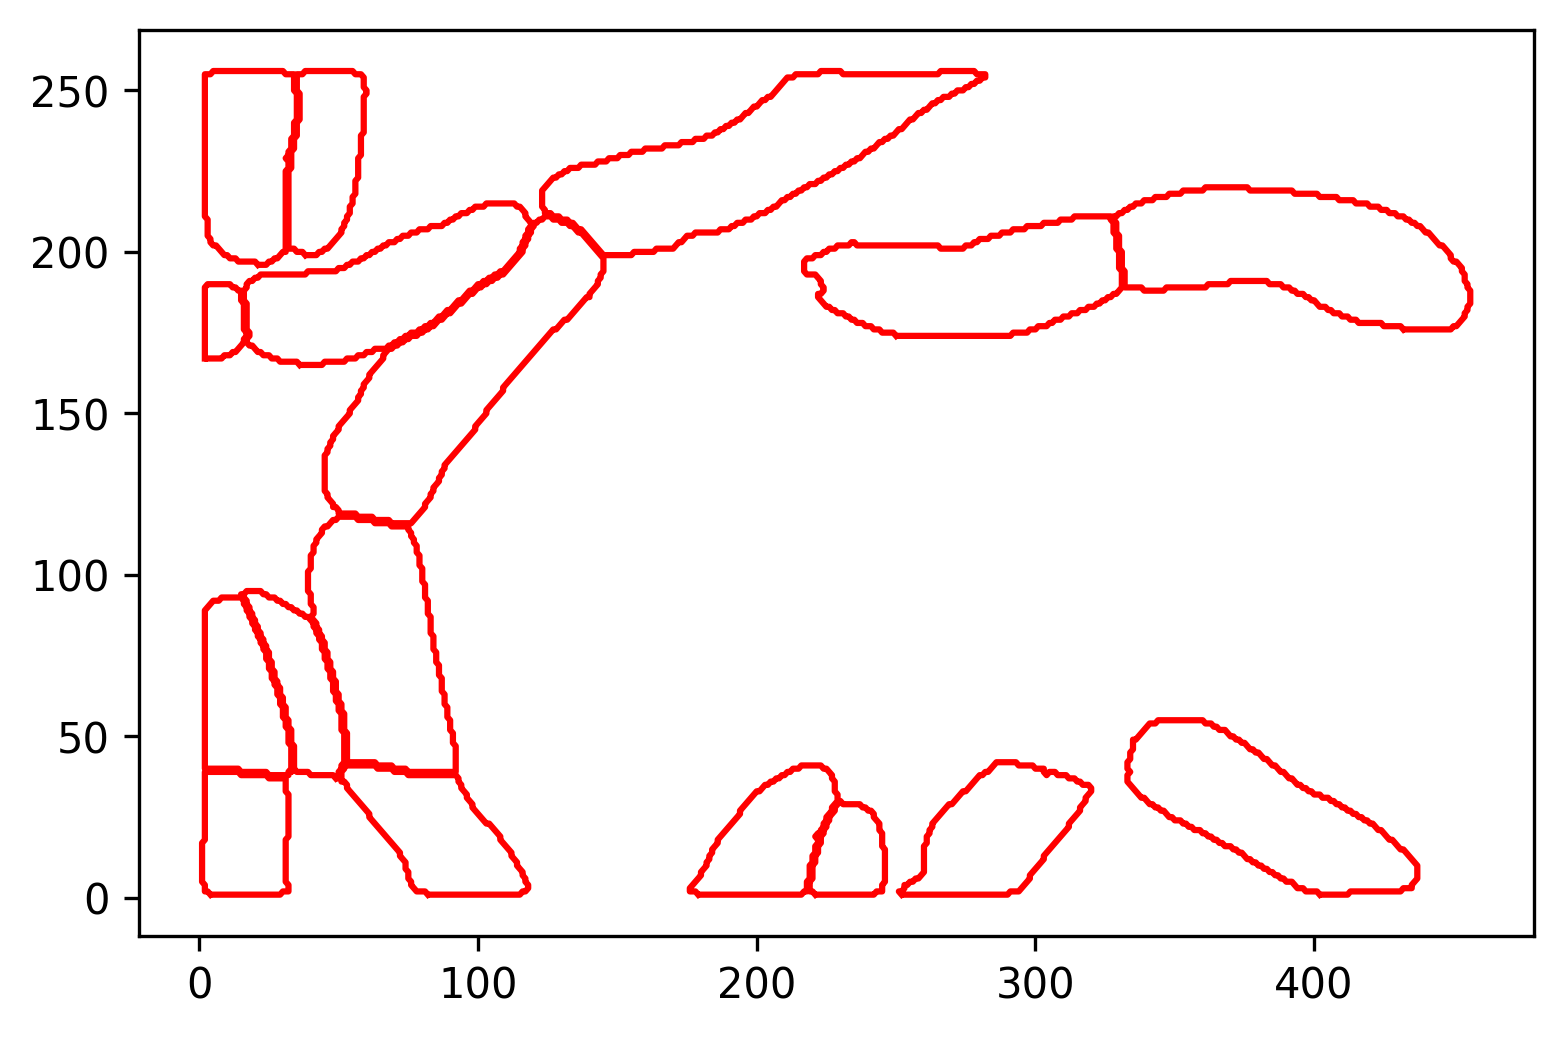

In [10]:
#plot just the outlines. 
outl = utils.outlines_list(dat['masks'])
for o in outl:
    plt.plot(o[:,0], o[:,1], color='r')


In [54]:
outl[2][:,0], outl[2][:,1]

(array([179, 178, 177, 176, 176, 177, 178, 179, 180, 180, 181, 182, 182,
        183, 183, 184, 184, 185, 186, 186, 187, 188, 189, 190, 191, 192,
        193, 194, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,
        205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
        218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 227, 228, 228,
        228, 228, 229, 229, 229, 228, 227, 227, 226, 225, 225, 224, 224,
        223, 223, 222, 221, 222, 222, 221, 221, 221, 220, 220, 220, 219,
        219, 219, 219, 219, 218, 218, 218, 218, 217, 216, 215, 214, 213,
        212, 211, 210, 209, 208, 207, 206, 205, 204, 203, 202, 201, 200,
        199, 198, 197, 196, 195, 194, 193, 192, 191, 190, 189, 188, 187,
        186, 185, 184, 183, 182, 181, 180]),
 array([ 1,  2,  2,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 33, 34, 35, 35, 36, 36, 37, 37, 38, 38, 39, 39, 40, 40, 40, 4

In [55]:
outl[3][:,0], outl[3][:,1]

(array([221, 220, 219, 219, 219, 219, 220, 220, 220, 220, 220, 221, 221,
        221, 222, 222, 222, 223, 223, 223, 224, 224, 225, 225, 226, 226,
        227, 228, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
        239, 240, 241, 242, 242, 243, 244, 244, 244, 245, 245, 245, 245,
        245, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 245,
        245, 245, 244, 243, 242, 241, 240, 239, 238, 237, 236, 235, 234,
        233, 232, 231, 230, 229, 228, 227, 226, 225, 224, 223, 222]),
 array([ 1,  2,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 29, 29, 29,
        29, 29, 29, 29, 28, 28, 27, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18,
        17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  2,
         2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1]))

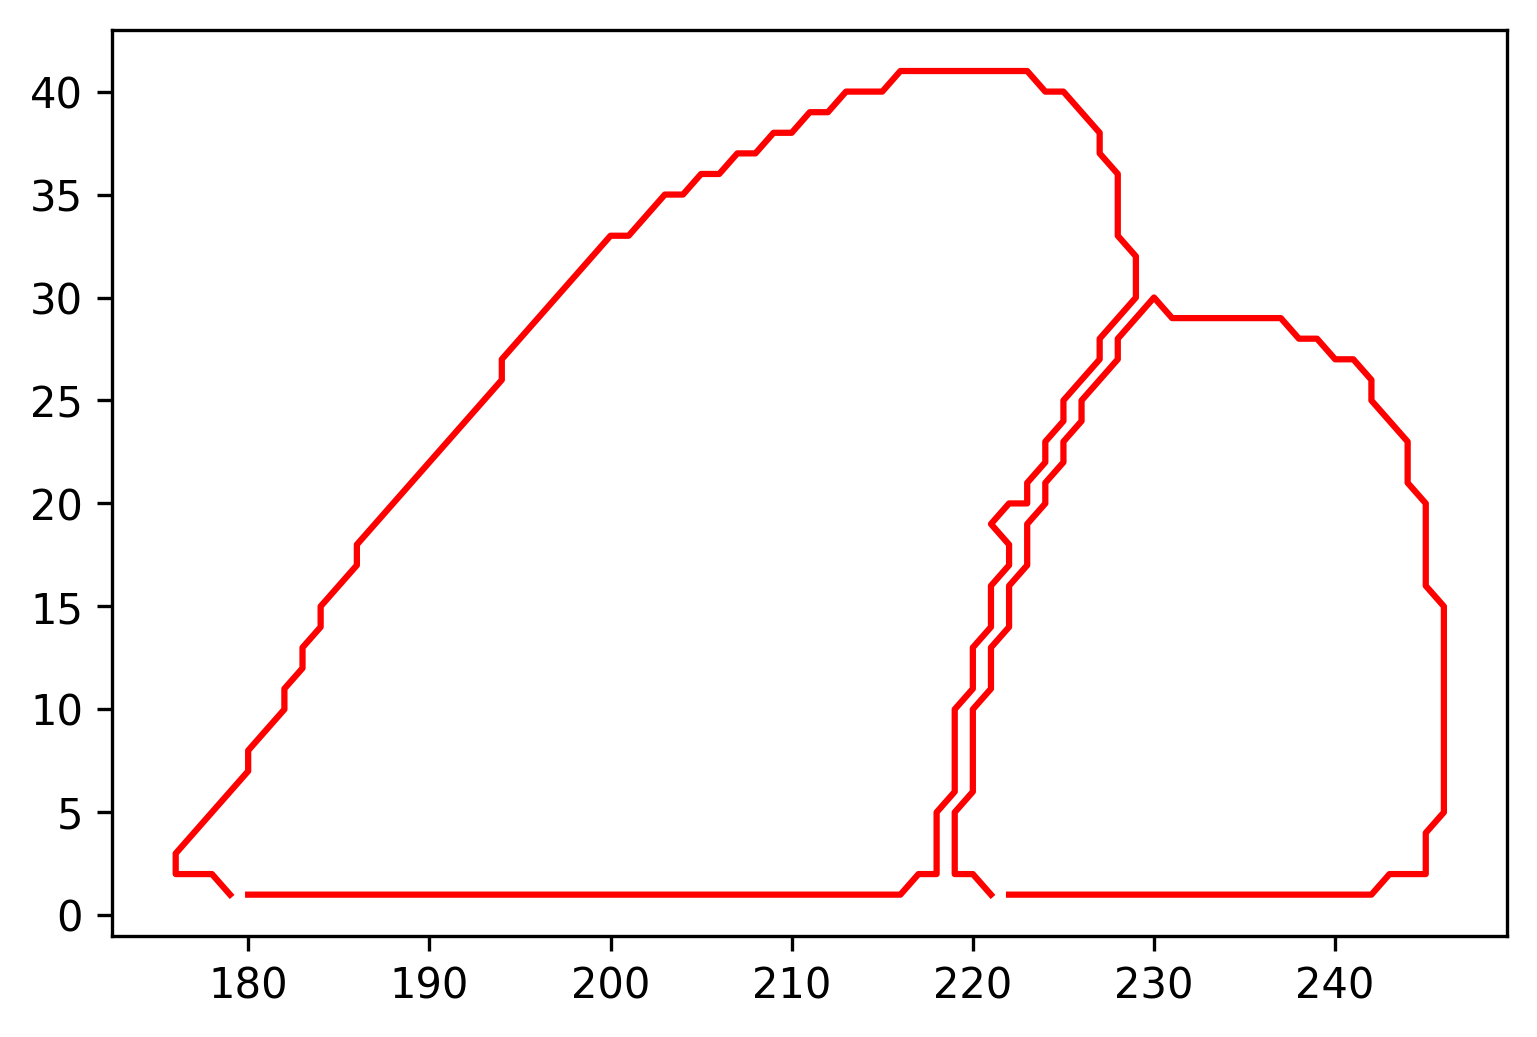

In [57]:
# plot an individual cell of choice. 
plt.plot(outl[3][:,0], outl[3][:,1], color = "r")
plt.plot(outl[2][:,0], outl[2][:,1], color = "r")
#plt.xlim((310,400))

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [75]:
adj = 0
for pixel1 in outl[3]:
    for pixel2 in outl[2]:
        distx = np.abs(pixel1[0]-pixel2[0])
        disty = np.abs(pixel1[1]-pixel2[1])
        if distx+disty == 1:
            adj = adj + 1

In [76]:
adj

39

In [ ]:
#OH SWEET GOD IN HEAVEN IT ACTUALLY KIND OF WORKED

for pixel in contour:
    for pixel2 in contour2:
        distx = np.abs(pixel[0]-pixel2[0])
        disty = np.abs(pixel[1]-pixel2[1])
        if distx+disty == 1:
            add one point to the overlap. 

And then I can add stuff together to get general distance as well? Honestly general distance can probably be solved with centroid measurements. 

Ok, so maybe I need to come at this on a pixel by pixel basis. Take each pixel, and have it scan all of the pixels that are 2 adjacent pixels away or more. If it finds even one that belongs to an different contour, then that pixel counts as a single "connected" pixel. this connectedness is added to a table with the metadata for each cell. Now how do I get it to ignore self pixels? 

Maybe an even better idea is to just measure closeness. Like, I take every pixel in a cell, and I measure its minimum distance to something else. If that minimum distance is 1 it is adjacent. If it is not 1 then they are not adjacent. 

Maybe simplify it all the way down to just finding adjacent pairs in the arrays? Like, it just looks through the arrays to find the nearly matching points? If I really do something like this, I would need somekind of filtering parameter, like only do this on cells that are at least this close based on a basic comparison on centroid distance. 

# Testing optical flow

In [24]:
import numpy as np
import cv2 as cv
import argparse

#parser = argparse.ArgumentParser(description='This sample demonstrates Lucas-Kanade Optical Flow calculation. \
                                              #The example file can be downloaded from: \
                                              #https://www.bogotobogo.com/python/OpenCV_Python/images/mean_shift_tracking/slow_traffic_small.mp4')
#parser.add_argument('image', type=str, help='path to image file')
#args = parser.parse_args()

cap = cv.VideoCapture("/home/keeganfl/Desktop/Math_612_project/AFM_Automation_code/slow_traffic_small.mp4")

### Oh dear lord...
It might honestly be easier to just port the files into another environment that has not been totally destroyed by whatever cellpose did to CV2. 

In [25]:
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0, 255, (100, 3))

# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)
p0 = cv.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

while(1):
    ret, frame = cap.read()
    if not ret:
        print('No frames grabbed!')
        break

    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    # calculate optical flow
    p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Select good points
    if p1 is not None:
        good_new = p1[st==1]
        good_old = p0[st==1]

    # draw the tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
        frame = cv.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)
    img = cv.add(frame, mask)

    cv.imshow('frame', img)
    k = cv.waitKey(30) & 0xff
    if k == 27:
        break

    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

cv.destroyAllWindows()

error: OpenCV(4.5.5) /io/opencv/modules/highgui/src/window.cpp:1268: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'
